In [1]:
import numpy as np
import matplotlib.pyplot as pl
np.random.seed(0)
figdir = "./fig/unsupervised-input-reconstruction/"

from functions import *

# Unsupervised input reconstruction

## Define input

In [2]:
niter_all = 400
nin = 1
its = np.array(range(niter_all))
ds = np.cos( (2*np.pi/100)*its ).reshape((nin, -1))
ds = np.hstack(
    [ds, 
     np.cos( (2*np.pi/200)*its ).reshape((nin, -1)) + np.sin( (2*np.pi/50)*its ).reshape((nin, -1)),
     ds**9
    ])
nin, niter_all = ds.shape

## Define and simulate ESN with RLS

In [3]:
nr = 50
Aamp = 0.02
Brho = 0.9
sig = np.tanh
arcsig = np.arctanh

def run_ESN_withRLS(nin, nr, Aamp, Brho, sig):
    A, B, g = gen_ESN(nin, nr, Aamp, Brho, sig)

    rs = np.zeros((nr, niter_all))
    
    Bhs = np.zeros((nr,nr,niter_all))
    Bhs[:,:,0] = B
    Ps = np.zeros((nr,nr,niter_all))
    Ps[:,:,0] = np.eye(nr)
    lam = 1

    WRs = np.zeros((nin,nr,niter_all))
    recs = np.zeros((nin, niter_all))
    
    for it in range(niter_all-1):
        rs[:, it+1] = g( ds[:, it], rs[:, it] )
        
        Ps[:,:,it+1], Bhs[:,:,it+1] = RLS_step(arcsig(rs[:, it]), rs[:, it+1], Bhs[:,:,it], Ps[:,:,it], lam)

        WRs[:,:,it+1] = pinv(A)@(Bhs[:,:,it+1] - B)
        recs[:,it+1] = WRs[:,:,it+1]@rs[:,it+1]

    return rs, Bhs, Ps, WRs, recs

nsmp = 10
results = [ run_ESN_withRLS(nin, nr, Aamp, Brho, sig) for _ in range(nsmp) ]

## Show a typical result

input dt
reservoir state rt
reconstruction WR@rt
|WR_t+1 - WR_t|


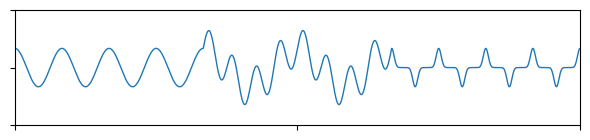

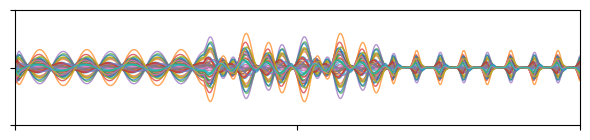

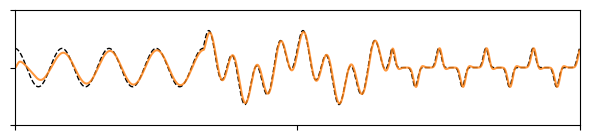

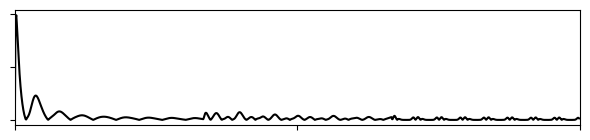

In [7]:
rs, Bhs, Ps, WRs, recs = results[0]
figsize = (6,1.5)


pl.figure(figsize=figsize)
pl.plot(ds[0, :], lw=1)
pl.yticks([-3, 0, 3], [])
pl.ylim([-3, 3])
pl.xticks( [0, 600, 1200], [])
pl.xlim([0, 1200])
pl.tight_layout()
pl.savefig(figdir+"input.pdf")
print("input dt")


pl.figure(figsize=figsize)
for i in range(nr):
    pl.plot(rs[i, :], lw=1, alpha=0.7)
pl.yticks([-0.3, 0, 0.3], [])
pl.ylim([-0.3, 0.3])
pl.xticks( [0, 600, 1200], [])
pl.xlim([0, 1200])
pl.tight_layout()
pl.savefig(figdir+"reservoir.pdf")
print("reservoir state rt")

pl.figure(figsize=figsize)
pl.plot(ds[0, :], "--k", lw=1)
pl.plot( recs[0,:], "tab:orange", alpha=0.8)
pl.yticks([-3, 0, 3], [])
pl.ylim([-3, 3])
pl.xticks( [0, 600, 1200], [])
pl.xlim([0, 1200])
pl.tight_layout()
pl.savefig(figdir+"reconstruction.pdf")
print("reconstruction WR@rt")


pl.figure(figsize=figsize)
dWs = np.array( [ np.sqrt( Fnorm( WRs[:,:,it] - WRs[:,:,it-1] ) ) for it in range(1,niter_all) ] )
pl.plot( dWs, "k")
pl.xticks( [0, 600, 1200], [])
pl.xlim([0, 1200])
pl.yticks([0, 0.1, 0.2], [])
pl.tight_layout()
pl.savefig(figdir+"diff-W.pdf")
print("|WR_t+1 - WR_t|")

## Show avarage results

reconstruction WR@rt mean
|WR_t+1 - WR_t| mean


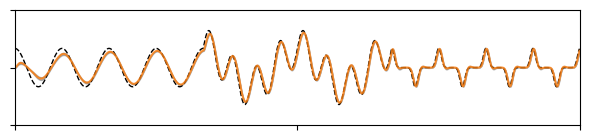

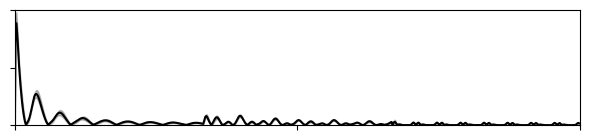

In [8]:
recs_mean = np.vstack( [ result[4] for result in results ] ).mean(axis=0)
recs_std = np.vstack( [ result[4] for result in results ] ).std(axis=0)

dWs_all = []
for result in results:
    WRs = result[3]
    dWs = np.array( [ np.sqrt( Fnorm( WRs[:,:,it] - WRs[:,:,it-1] ) ) for it in range(1,niter_all) ] )
    dWs_all.append(dWs)

dWs_mean = np.vstack( dWs_all ).mean(axis=0)
dWs_std = np.vstack( dWs_all ).std(axis=0)

figsize = (6,1.5)


pl.figure(figsize=figsize)
pl.plot(ds[0, :], "--k", lw=1)

pl.fill_between(range(niter_all), recs_mean-recs_std, recs_mean+recs_std, color="black", alpha=0.25)
pl.plot( recs_mean, "tab:orange", alpha=0.8)

pl.yticks([-3, 0, 3], [])
pl.ylim([-3, 3])
pl.xticks( [0, 600, 1200], [])
pl.xlim([0, 1200])
pl.tight_layout()
pl.savefig(figdir+"reconstruction-mean.pdf")
print("reconstruction WR@rt mean")


pl.figure(figsize=figsize)
pl.fill_between(range(niter_all-1), dWs_mean-dWs_std, dWs_mean+dWs_std, color="black", alpha=0.25)
pl.plot( dWs_mean, "k")
pl.xticks( [0, 600, 1200], [])
pl.xlim([0, 1200])
pl.yticks([0, 0.1, 0.2], [])
pl.ylim([0,0.2])
pl.tight_layout()
pl.savefig(figdir+"diff-W-mean.pdf")
print("|WR_t+1 - WR_t| mean")

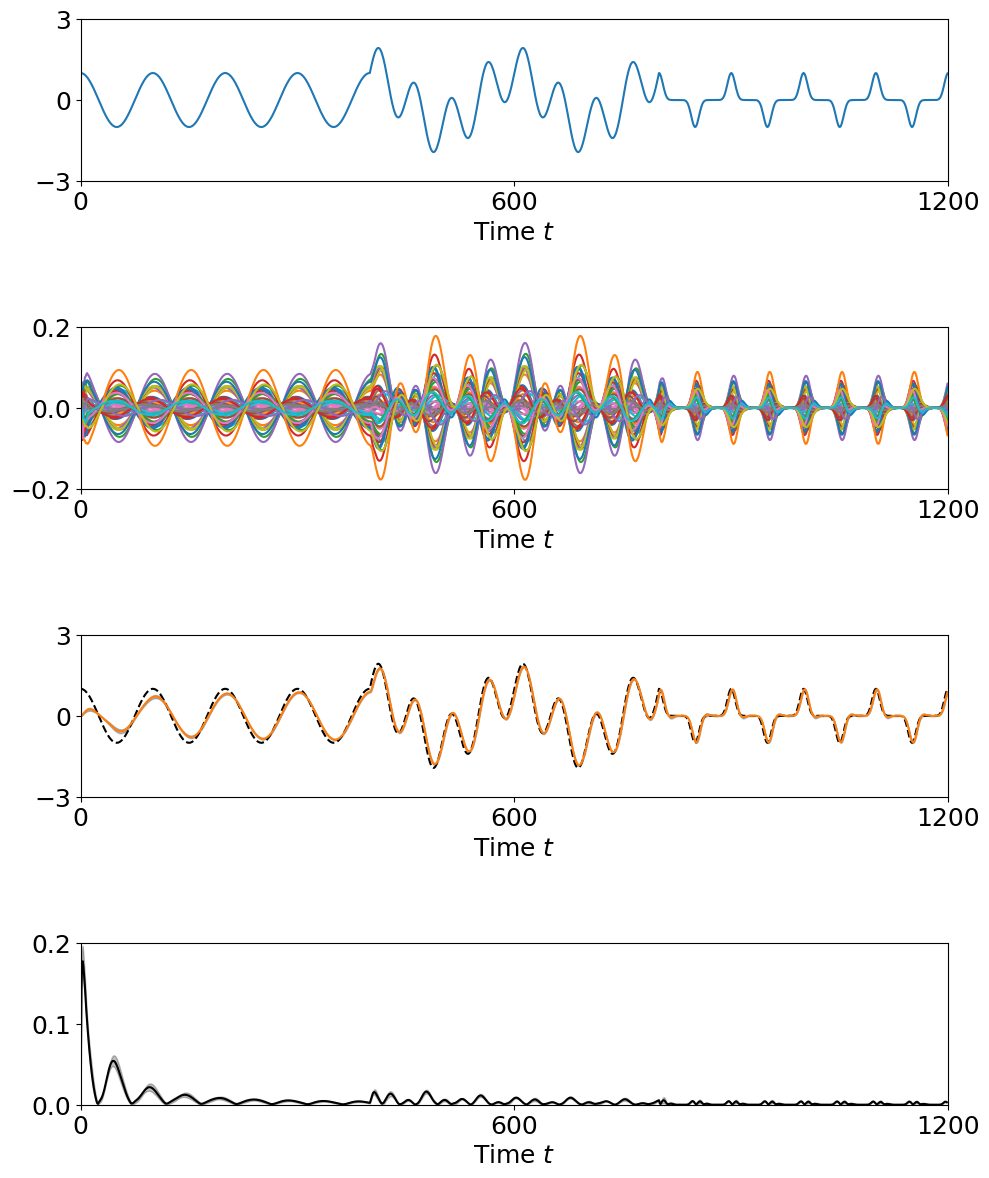

In [72]:
def general_setting(ax):
    fontsize = 18
    ax.set_xlim([0, 1200])
    ax.set_xlabel(r"Time $t$", fontdict={'fontsize': fontsize})
    ax.set_xticks([0, 600, 1200])
    pl.setp(ax.get_xticklabels(), fontsize=fontsize)
    pl.setp(ax.get_yticklabels(), fontsize=fontsize)
    

figsize = (10,12)
fig = pl.figure(figsize=figsize)

ax = fig.add_subplot(4,1,1)
ax.plot(ds[0, :])
ax.set_ylim([-3,3])
ax.set_yticks([-3, 0, 3])
general_setting(ax)


ax = fig.add_subplot(4,1,2)
for i in range(nr):
    ax.plot(rs[i, :])
ax.set_yticks([-0.2, 0, 0.2])
ax.set_ylim([-0.2,0.2])
general_setting(ax)

ax = fig.add_subplot(4,1,3)
ax.fill_between(range(niter_all), recs_mean-recs_std, recs_mean+recs_std, color="black", alpha=0.25)
ax.plot(ds[0, :], "k--")
ax.plot(recs_mean, color="tab:orange")
ax.set_yticks([-3, 0, 3])
ax.set_ylim([-3,3])
general_setting(ax)

ax = fig.add_subplot(4,1,4)
ax.fill_between(range(niter_all-1), dWs_mean-dWs_std, dWs_mean+dWs_std, color="black", alpha=0.25)
ax.plot( dWs_mean, "k")
ax.set_yticks([0, 0.1, 0.2])
ax.set_ylim([0,0.2])
general_setting(ax)

pl.tight_layout()
pl.subplots_adjust(top=0.97, hspace=0.9)
pl.savefig(figdir+"all.pdf")